In [2]:
import numpy as np
from OptimumFilter import *
from trace_IO import *
import matplotlib.pyplot as plt
from scipy.stats import describe
import glob

sampling_frequency = 3906250  # Hz
noise_psd = np.load("../../../templates/noise_psd_from_MMC.npy")
sum_psd = 9*noise_psd
template = np.load("sum_qp_template_1800.npy")
sum_of = OptimumFilter(template, sum_psd, sampling_frequency)
# Define the sampling frequency for your data
sampling_frequency = 3906250  # Hz

channel_traces_directory = "individual_vac_1800/"


channel_trace_files = glob.glob(os.path.join(channel_traces_directory, "channel_*_normalized_trace.npy"))

channel_optimum_filters = {}

print("\n--- Creating Channel-wise Optimum Filters ---")
for file_path in sorted(channel_trace_files): # Sort for consistent order
    # Extract the channel number from the filename (e.g., 'channel_45_normalized_trace.npy' -> 45)
    file_name = os.path.basename(file_path)
    channel_number = int(file_name.split('_')[1])

    # Load the normalized trace for the current channel to use as its template
    channel_template = np.load(file_path) # Use your actual trace loading function here
    of = OptimumFilter(channel_template, noise_psd, sampling_frequency)

    # Store the created optimum filter in the dictionary
    channel_optimum_filters[channel_number] = of




--- Creating Channel-wise Optimum Filters ---


In [5]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import describe

sampling_frequency = 3906250  # Hz
noise_psd = np.load("../../../templates/noise_psd_from_MMC.npy")
sum_psd = 9*noise_psd
template = np.load("sum_qp_template_1800.npy")
sum_of = OptimumFilter(template, sum_psd, sampling_frequency)


Processing Summed: 100%|██████████| 32/32 [02:56<00:00,  5.51s/it]


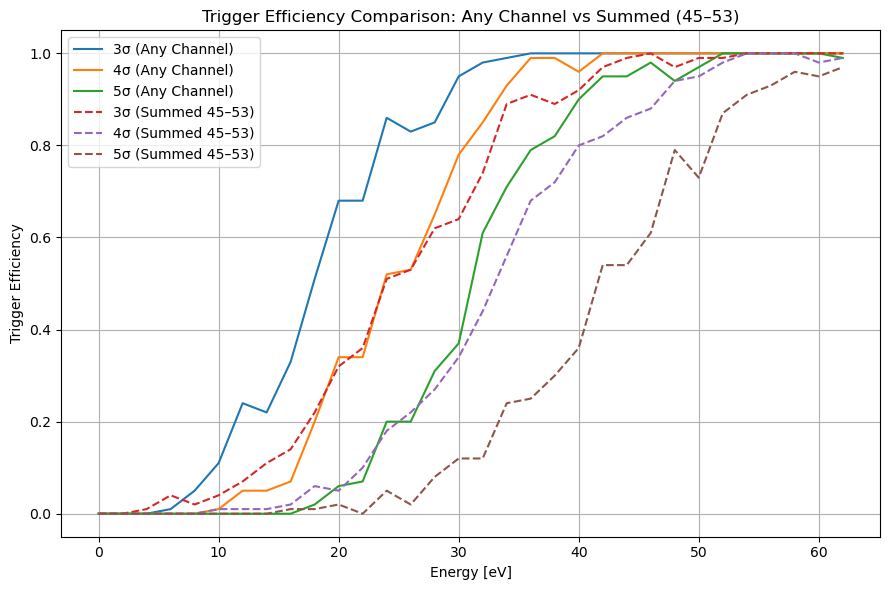

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# --- Channel-based (per-channel) threshold trigger ---

# Define thresholds using vacuum std values from quantized noise
channel_std = {
    45: 0.8440, 46: 0.7196, 47: 0.7514, 48: 0.7595, 49: 0.7367,
    50: 0.8430, 51: 0.6612, 52: 0.7112, 53: 0.6817,
}
thresholds_channel = {
    n: {ch: sigma * n for ch, sigma in channel_std.items()}
    for n in [3, 4, 5]
}

# Base path for files
base_path = Path("/ceph/dwong/trigger_samples/qp_sample")
file_paths = sorted(base_path.glob("QP_sample_quantized_*eV.zst"))

# Extract energy values from filenames
def extract_energy(fp):
    match = re.search(r'_(\d+)eV', fp.stem)
    return int(match.group(1)) if match else -1

file_paths = sorted(file_paths, key=extract_energy)
energies = [extract_energy(fp) for fp in file_paths]

# Store results for channel-based method
efficiency_results_channels = {thr: [0.0] * len(file_paths) for thr in thresholds_channel}

def process_file(index, energy, path):
    quantized_traces = load_traces_from_zstd(str(path), n_traces=100)  # shape (100, 54, 32768)
    triggered_counts = {thr: 0 for thr in thresholds_channel}

    for trace_set in quantized_traces:
        channel_amplitudes = []
        for ch in range(45, 54):
            amp, _ = channel_optimum_filters[ch].fit(trace_set[ch])
            channel_amplitudes.append((ch, amp))

        for thr_val in thresholds_channel:
            for ch, amp in channel_amplitudes:
                if amp > thresholds_channel[thr_val][ch]:
                    triggered_counts[thr_val] += 1
                    break

    return index, {
        thr_val: triggered_counts[thr_val] / len(quantized_traces)
        for thr_val in thresholds_channel
    }

# Run in parallel
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(process_file, i, e, p) for i, (e, p) in enumerate(zip(energies, file_paths))]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Channel-Based"):
        idx, result = future.result()
        for thr_val in result:
            efficiency_results_channels[thr_val][idx] = result[thr_val]

# --- Summed-channel trigger ---

# Thresholds based on noise std of the summed channel
threshold_base = 2.1476
threshold_values_sum = [threshold_base * n for n in [3, 4, 5]]
efficiency_results_sum = {thr: [] for thr in threshold_values_sum}

for energy, path in tqdm(zip(energies, file_paths), total=len(file_paths), desc="Processing Summed"):
    quantized_trace = load_traces_from_zstd(str(path), n_traces=100)  # shape (100, 54, 32768)
    
    amplitudes = []
    for trace_set in quantized_trace:
        sum_trace = np.sum(trace_set[45:], axis=0)
        amp = sum_of.fit(sum_trace)
        amplitudes.append(amp)
    
    amplitudes = np.array(amplitudes)
    
    for thr in threshold_values_sum:
        pass_rate = np.sum(amplitudes > thr) / len(amplitudes)
        efficiency_results_sum[thr].append(pass_rate)

# --- Plotting combined results ---

plt.figure(figsize=(9, 6))

# Plot individual channel-based trigger (solid lines)
for thr_val in sorted(efficiency_results_channels):
    plt.plot(
        energies,
        efficiency_results_channels[thr_val],
        label=f"{thr_val}σ (Any Channel)",
        linestyle='-'
    )

# Plot summed-trace trigger (dashed lines)
for n, thr_val in zip([3, 4, 5], threshold_values_sum):
    plt.plot(
        energies,
        efficiency_results_sum[thr_val],
        label=f"{n}σ (Summed 45–53)",
        linestyle='--'
    )

plt.xlabel("Energy [eV]")
plt.ylabel("Trigger Efficiency")
plt.title("Trigger Efficiency Comparison: Any Channel vs Summed (45–53)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


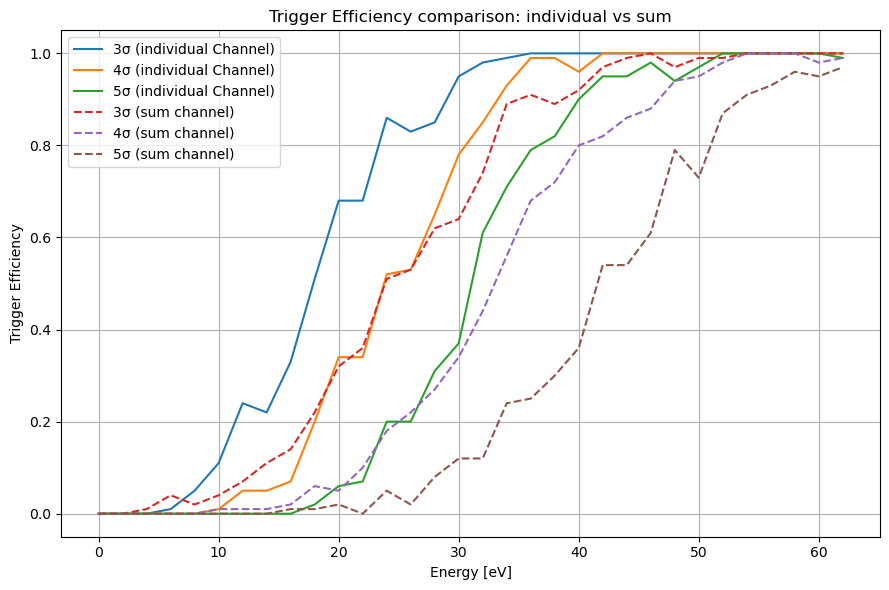

In [8]:
plt.figure(figsize=(9, 6))

# Plot individual channel-based trigger (solid lines)
for thr_val in sorted(efficiency_results_channels):
    plt.plot(
        energies,
        efficiency_results_channels[thr_val],
        label=f"{thr_val}σ (individual Channel)",
        linestyle='-'
    )

# Plot summed-trace trigger (dashed lines)
for n, thr_val in zip([3, 4, 5], threshold_values_sum):
    plt.plot(
        energies,
        efficiency_results_sum[thr_val],
        label=f"{n}σ (sum channel)",
        linestyle='--'
    )

plt.xlabel("Energy [eV]")
plt.ylabel("Trigger Efficiency")
plt.title("Trigger Efficiency comparison: individual vs sum")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


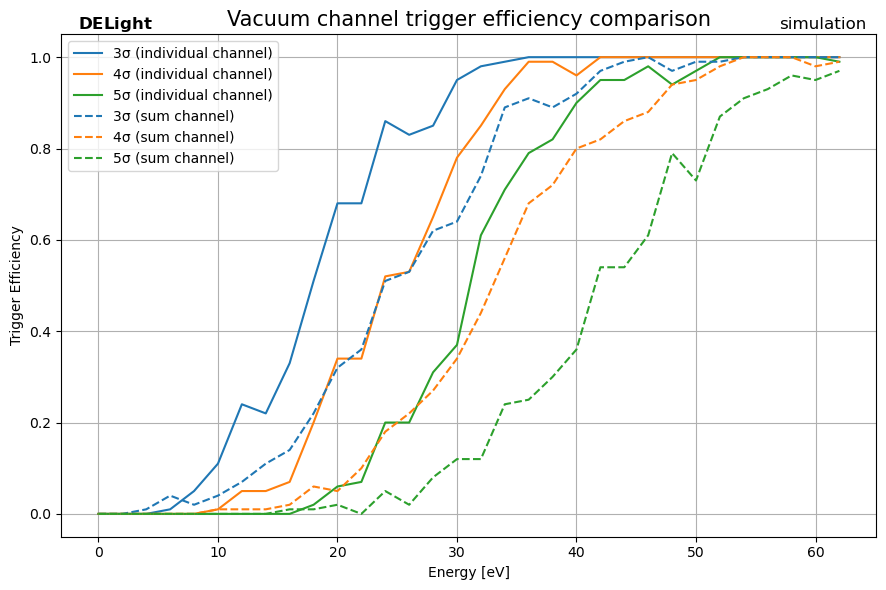

In [17]:
import matplotlib.pyplot as plt
from itertools import cycle

# Create figure and axis explicitly
fig, ax = plt.subplots(figsize=(9, 6))

# Define color cycle to ensure consistent colors for same sigma
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
sigma_levels = [3, 4, 5]
color_map = {sigma: next(colors) for sigma in sigma_levels}

# Plot individual channel-based trigger (solid lines)
for sigma in sigma_levels:
    ax.plot(
        energies,
        efficiency_results_channels[sigma],
        label=f"{sigma}σ (individual channel)",
        linestyle='-',
        color=color_map[sigma]
    )

# Plot summed-trace trigger (dashed lines)
threshold_values_sum = [2.1476 * n for n in sigma_levels]
for sigma, thr_val in zip(sigma_levels, threshold_values_sum):
    ax.plot(
        energies,
        efficiency_results_sum[thr_val],
        label=f"{sigma}σ (sum channel)",
        linestyle='--',
        color=color_map[sigma]
    )

# Add annotation text
ax.text(0.02, 1.01, r'$\mathbf{DELight}$', transform=ax.transAxes, fontsize=12, fontweight='bold')
ax.text(0.88, 1.01, "simulation", transform=ax.transAxes, fontsize=12)

# Labels, title, legend, etc.
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Trigger Efficiency")
ax.set_title("Vacuum channel trigger efficiency comparison", fontsize=15)
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()
